In [1]:
import struct

# see CDAS git /Raid/src/Utils/CL/cl_msg_unknown_pack.h
def read_package(f) -> dict:

    package = {}

    # pack Header
    package['LsId'] = int.from_bytes(f.read(2), byteorder='little')
    n_packs = int.from_bytes(f.read(2), byteorder='little')
    timestamp_sec = int.from_bytes(f.read(4), byteorder='little')
    timestamp_nsec = int.from_bytes(f.read(4), byteorder='little')
    total_size = int.from_bytes(f.read(4), byteorder='little')

    for i in range(n_packs):

        # header i
        type = int.from_bytes(f.read(4), byteorder='little')
        version = int.from_bytes(f.read(4), byteorder='little')
        size = int.from_bytes(f.read(4), byteorder='little')
        data = f.read(size)

        package[str(i)] = {'type': type,
                        'version': version,
                        'size': size,
                        'data': data}

    return package

examples = [] 
with open('/home/filip/Desktop/didi-synvc/monit_2024_11_26.packs.nobackup', 'rb') as f:
    while f.read(8) == b'!monit!!':
        examples.append(read_package(f))

In [2]:
import numpy as np

peaks = []

for e in examples:
        data = e['1']['data']
        peaks.append([struct.unpack('d', data[i:i+8])[0] for i in range(0, len(data), 8)])

peaks = np.array(peaks)

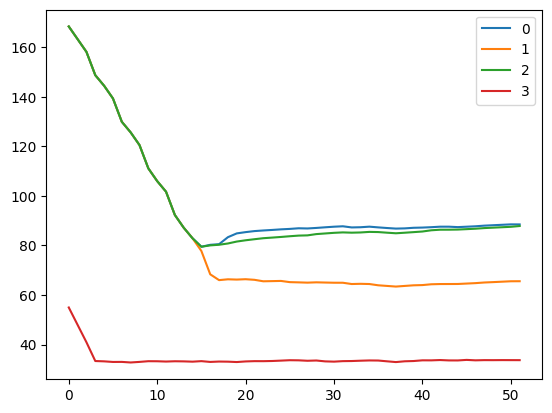

In [3]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.plot(range(len(peaks)), peaks[:, i], label=i)

plt.legend()